# Create nnUNet data and dataset json
---
### Nadieh

I use this command for my interactive job:

~/c-submit --priority=high --gpu-count=1 --require-gpu-mem=10G --require-mem=32G --require-cpus=8 --node=dlc-ditto --interactive --env CODEBASE=/data/pathology/projects/pathology-lung-TIL joeyspronck 9974 4 doduo1.umcn.nl/pathology_lung_til/nnunet:9.4-midl2023

In [1]:
from savenifti import convert_2d_image_to_nifti
from polygon import convert_polygons_to_annotations, get_tissue_union_from_mask
from filepath import convert_path, GenerateJson

# Libraries

In [2]:
import os
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.image.wholeslideimage import WholeSlideImage
#from wholeslidedata.accessories.asap.parser import AsapAnnotationParser
from matplotlib import pyplot as plt
from wholeslidedata.samplers.patchlabelsampler import SegmentationPatchLabelSampler
from shapely.geometry import Point
import numpy as np
import pandas as pd
import SimpleITK as sitk
from wholeslidedata.annotation.utils import cv2_polygonize
from shapely import geometry
from wholeslidedata.labels import Label
from wholeslidedata.annotation.structures import Annotation

In [3]:
# !pip3 install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main
# !pip3 install --upgrade opencv-python-headless
# # # sudo apt update && sudo apt -y upgrade && sudo apt-get install -y openslide-tools
# restart kernel


# Data import

In [3]:
import yaml
import random
import os
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"
camelyon_path = convert_path('/data/pathology/projects/pathology-mrifuse/yaml/data_camelyon17.yaml', current_os)
with open(camelyon_path, 'r') as f:
    yaml = yaml.safe_load(f)
root = yaml['path']['root']
camelyon = yaml['path']['camelyon17']     
train_data = yaml['data']['training']


## Combine

This iteration I combine the new batch with the original train data to check if we indeed improved upon the mistakes we identified in the original test set (we chose new ROIs to address specific mistakes we identified in the test data).

### Whole Slide Data

### Colormap ASAP and labels

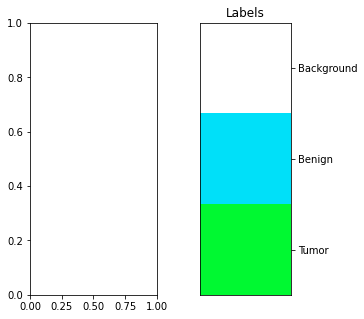

In [7]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
# import pylab as plt

colormap = [ [ 0, 0, 0, 0 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 0, 249, 50, 255 ] ]
colormap = np.array(colormap)/255.
cmap = LinearSegmentedColormap.from_list('my_cmap', colors=colormap)

label_names = ['Background','Benign','Tumor']
label_index = list(range(len(label_names)))
n_labels = len(label_names)
label_plot_args = {"cmap":cmap, "vmin":0, "vmax":255, "interpolation":"none"}


%matplotlib inline

# easy to copy paste in figures this way
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[-1].imshow([[i] for i in list(range(3))], **label_plot_args)
axs[-1].set_yticks(label_index)
axs[-1].set_yticklabels(label_names)
axs[-1].yaxis.tick_right()
axs[-1].get_xaxis().set_visible(False)
axs[-1].set_title("Labels")
plt.show()

# Check images and annotations, gather pixel label distribution data for generating splits

In [5]:
labels={'Background':0,
        'Benign': 1, 
        'Tumor': 2}
nnUNet_data_root 


NameError: name 'nnUNet_data_root' is not defined

In [2]:
import os
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"
nnUNet_base = r"B:\projects\pathology-mrifuse"
nnUNet_data_root = convert_path(os.path.join(nnUNet_base, "nnUNet_raw_data"), current_os)
sorted(os.listdir(nnUNet_data_root))
task_name = 'Task028_camelyon_uncertainty'
task_root = os.path.join(nnUNet_data_root, task_name)
task_root = convert_path(task_root, current_os)
print("TASK:\t\t", task_name)
nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)
print("nnUNet ROOT:\t", nnUNet_base_linux)
image_folder = os.path.join(task_root, "imagesTr")
image_folder = convert_path(image_folder, current_os)
label_folder = os.path.join(task_root, "labelsTr")
label_folder = convert_path(label_folder, current_os)
if not(os.path.isdir(image_folder)):
    os.makedirs(image_folder)
if not(os.path.isdir(label_folder)):
    os.makedirs(label_folder)

TASK:		 Task028_camelyon_uncertainty
nnUNet ROOT:	 B:\projects\pathology-mrifuse


In [7]:
from shapely.geometry import Point, Polygon
patch_size = (1024,1024)
#sample every 100 pixel
sample_rate = patch_size[0]*patch_size[1]
plot = False
contrast_value = 20000 #remove white patch--- masks are bad quality
save = True
spacing = 1
# 'rst', 'umcu','rumc', 'lpon','cwz'
center_list = ['rst', 'umcu','rumc', 'lpon','cwz']
cancer_list = [ 'negative','itc', 'micro','macro']
# counts_wsi = np.zeros(n_labels)
for sample_per_slide in range(100,140,30):
    
    task_name = f'Task028_camelyon_uncertainty_{sample_per_slide}'
    task_root = os.path.join(nnUNet_data_root, task_name)
    task_root = convert_path(task_root, current_os)
    print("TASK:\t\t", task_name)
    nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)
    print("nnUNet ROOT:\t", nnUNet_base_linux)
    image_folder = os.path.join(task_root, "imagesTr")
    image_folder = convert_path(image_folder, current_os)
    label_folder = os.path.join(task_root, "labelsTr")
    label_folder = convert_path(label_folder, current_os)
    if not(os.path.isdir(image_folder)):
        os.makedirs(image_folder)
    if not(os.path.isdir(label_folder)):
        os.makedirs(label_folder)
    for center in center_list:
        for cancer in cancer_list:
            path = train_data['{}/{}'.format(cancer, center)]
            for i in path:
                image = convert_path(i['image'].format(root='/data/pathology',camelyon17=camelyon), to = current_os)  
                mask = convert_path(i['mask'].format(root='/data/pathology',camelyon17=camelyon), to = current_os)
                filename = os.path.basename(image)[:-4]
                print(image)
                s = os.path.split(image)[-1].split(".")[-2]

                wsi = WholeSlideImage(image, backend="asap")
                wsi_mask = WholeSlideImage(mask, backend="asap")
                tissues = get_tissue_union_from_mask(wsi_mask, wsi,spacing,value = 1, fill_holes = True)


                for sample in range(int(sample_per_slide)):

                    point = Point(0, 0)
                    list_min_x = [np.min(tissues[i].coordinates[:,0]) for i in range(len(tissues))]
                    list_max_x = [np.max(tissues[i].coordinates[:,0]) for i in range(len(tissues))]
                    list_min_y = [np.min(tissues[i].coordinates[:,1]) for i in range(len(tissues))]
                    list_max_y = [np.max(tissues[i].coordinates[:,1]) for i in range(len(tissues))]
                    while not any(tissue.contains(point) for tissue in tissues):
                        random_center_x = random.randint(int(min(list_min_x)),int(max(list_max_x)))
                        random_center_y = random.randint(int(min(list_min_y)),int(max(list_max_y)))
                        point = Point(random_center_x, random_center_y)
                    image_patch = wsi.get_patch(random_center_x,random_center_y, patch_size[0], patch_size[1], spacing)
                    mask_patch = wsi_mask.get_patch(random_center_x,random_center_y, patch_size[0], patch_size[1], spacing)
                    output_filename = filename+ '_{}'.format(sample)
                    if save:
                        convert_2d_image_to_nifti(image_patch, os.path.join(image_folder, output_filename))
                        convert_2d_image_to_nifti(mask_patch, os.path.join(label_folder, output_filename), is_seg=True)      
                    vals = image_patch.flatten
                    # calculate histogram
                    counts, bins = np.histogram(image_patch, range(255))
                    contrast = np.sum(counts)
                    if contrast<contrast_value:
                        continue

                    if plot:
                        ratio = [14, 2]
                        fig, axs = plt.subplots(1,4,figsize=(15,4),gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
                        fig.suptitle(s+"_ROI"+str(sample), fontsize=15)

                        # ROI
                        axs[0].imshow(image_patch, **label_plot_args)
                        axs[0].axis('off')
                        axs[0].set_title("ROI")

                        # Ground truth tissue
                        axs[1].imshow(mask_patch) 
                        axs[1].axis('off')
                        axs[1].set_title("Ground truth tissue")

                        # Overlay
                        axs[2].imshow(image_patch)
                        axs[2].imshow(mask_patch, alpha=0.5, **label_plot_args) 
                        axs[2].axis('off')
                        axs[2].set_title("Overlay")

                        # Labels                
                        axs[3].imshow([[i] for i in list(range(len(label_index)))], **label_plot_args)
                        axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
                        axs[3].set_yticklabels(label_names)
                        axs[3].yaxis.tick_right()
                        axs[3].get_xaxis().set_visible(False)
                        axs[3].set_title("Labels")

                        plt.tight_layout()
                        plt.show()



TASK:		 Task028_camelyon_uncertainty_100
nnUNet ROOT:	 B:\projects\pathology-mrifuse
B:\archives\breast\camelyon\CAMELYON17\images\patient_022_node_3.tif


C:\Users\z433290\AppData\Local\anaconda3\envs\nnunet\lib\site-packages\wholeslidedata\image\wholeslideimage.py:88: UserWarning: Trying to load slide at spacing<2.0...
  warnings.warn(


TypeError: __new__() got an unexpected keyword argument 'index'

In [3]:
from savenifti import convert_2d_image_to_nifti
from polygon import convert_polygons_to_annotations, get_tissue_union_from_mask
from filepath import convert_path, GenerateJson
import os
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.image.wholeslideimage import WholeSlideImage
#from wholeslidedata.accessories.asap.parser import AsapAnnotationParser
from matplotlib import pyplot as plt
from wholeslidedata.samplers.patchlabelsampler import SegmentationPatchLabelSampler
from shapely.geometry import Point
import numpy as np
import pandas as pd
import SimpleITK as sitk
from wholeslidedata.annotation.utils import cv2_polygonize
from shapely import geometry
from wholeslidedata.labels import Label
from wholeslidedata.annotation.structures import Annotation
import yaml
import random
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"
camelyon_path = convert_path('/data/pathology/projects/pathology-mrifuse/yaml/data_camelyon17.yaml', current_os)
with open(camelyon_path, 'r') as f:
    yaml = yaml.safe_load(f)
root = yaml['path']['root']
camelyon = yaml['path']['camelyon17']     
train_data = yaml['data']['training']
labels={'Background':0,
        'Benign': 1, 
        'Tumor': 2}

current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"
nnUNet_base = r"B:\projects\pathology-mrifuse"
nnUNet_data_root = convert_path(os.path.join(nnUNet_base, "nnUNet_raw_data"), current_os)
nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)
print("nnUNet ROOT:\t", nnUNet_base_linux)

#'umcu','rumc',  'cwz', 


for i,sample_per_slide in zip([31],[40]):
    #30,31,32,33,
    #range(10,140,30)
    task_name = f'Task0{i}_camelyon_with_uncertainty_{sample_per_slide}'
    task_root = os.path.join(nnUNet_data_root, task_name)
    task_root = convert_path(task_root, current_os)
    print("TASK:\t\t", task_name)
    nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)
    print("nnUNet ROOT:\t", nnUNet_base_linux)
    image_folder = os.path.join(task_root, "imagesTr")
    image_folder = convert_path(image_folder, current_os)
    label_folder = os.path.join(task_root, "labelsTr")
    label_folder = convert_path(label_folder, current_os)


    label_folder = convert_path(label_folder, current_os)

    dataset_path = task_root
    GenerateJson(dataset_path)

nnUNet ROOT:	 B:\projects\pathology-mrifuse
TASK:		 Task031_camelyon_with_uncertainty_40
nnUNet ROOT:	 B:\projects\pathology-mrifuse


In [17]:
output_filename

NameError: name 'output_filename' is not defined

In [18]:


output_filename = filename+ '_{}'.format(sample)


NameError: name 'sample' is not defined

In [ ]:

tissues[0].coordinates

In [ ]:
path[12:]

In [ ]:
output_filename = filename+ '_{}'.format(idx)+'_{}'.format(sample)


In [ ]:
path

In [ ]:
from sklearn.model_selection import KFold

## Loss on distributions

### Claculate the mean MSE losses over percentages of indivudual folds and their mean

In [ ]:
wsi_or_roi_based = 'roi'

In [ ]:
if wsi_or_roi_based == 'wsi':
    print_best_dist_loss(val_distribution_losses)
    print_best_dist_loss(val_distribution_losses_log)

In [ ]:
if wsi_or_roi_based == 'roi':
    print_best_dist_loss(train_distribution_losses)
    print_best_dist_loss(train_distribution_losses_log)

In [ ]:
if wsi_or_roi_based == 'roi':
    print_best_dist_loss(val_distribution_losses)
    print_best_dist_loss(val_distribution_losses_log)

# Final split

### WSI based

### ROI based

# Create nnUNet dataset (TRAIN)

Change Task name here for a new project:

In [9]:
import os
task_name = f'Task130_camelyon_uncertainty_130'
task_root = os.path.join(nnUNet_data_root, task_name)
task_root = convert_path(task_root, current_os)
print("TASK:\t\t", task_name)
nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)
print("nnUNet ROOT:\t", nnUNet_base_linux)
image_folder = os.path.join(task_root, "imagesTr")
image_folder = convert_path(image_folder, current_os)
label_folder = os.path.join(task_root, "labelsTr")
label_folder = convert_path(label_folder, current_os)
os.makedirs(image_folder, exist_ok=True)
os.makedirs(label_folder, exist_ok=True)
dataset_path = task_root
GenerateJson(dataset_path)

TASK:		 Task130_camelyon_uncertainty_130
nnUNet ROOT:	 /data/pathology/projects/pathology-mrifuse


In [23]:
nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)


### Makedirs
First check ofc

dataset_path

In [39]:
label_folder

'B:\\projects\\pathology-mrifuse\\nnUNet_raw_data\\Task028_camelyon_uncertainty_130\\labelsTr'

### Make dataset json

# Run nnUNet TRAIN job

In [29]:
print("TASK:\t\t", task_name)
nnUNet_base_linux = convert_path(nnUNet_base, to="linux")
print("nnUNet ROOT:\t", nnUNet_base_linux)

TASK:		 Task028_camelyon_uncertainty
nnUNet ROOT:	 /data/pathology/projects/pathology-mrifuse


## Set docker, trainer, and experiment planner

### Current docker:
'doduo1.umcn.nl/pathology_lung_til/nnunet:9.0-midl2023'

### how I made the docker
on cluster 

clone diag nnunet wrapper (into project folder)

checkout my feature branch that allows changing the plans and experiment planner, derived from feature branch from max de grauw

take the docker file there (which uses the cloned repo's wrapper.py file (maybe incorrect name))

copy your own specific docker commands below it

build and push it (change name in build.sh file)

voila

In [7]:
# docker = 'doduo1.umcn.nl/pathology_lung_til/nnunet:8.7-pathology_DA-latest'
docker = 'doduo1.umcn.nl/pathology_lung_til/nnunet:9.4-midl2023'

# trainer_name = 'nnUNetTrainerV2' #default
trainer_name = 'nnUNetTrainerV2_BN'
#trainer_name = 'nnUNetTrainerV2_BN_pathology_DA_hed005'
# trainer_name = 'nnUNetTrainerV2_BN_pathology_DA_hed005_hsv010'

# experiment_planner = 'ExperimentPlanner2D_v21_RGB_z_score_default' # this is a compatibility wrapper of the default
# experiment_planner = 'ExperimentPlanner2D_v21_RGB_z_score_default_bs2_ps1024'
# experiment_planner = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1'
# experiment_planner = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs2_ps1024'
experiment_planner = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512'
# experiment_planner = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs32_ps256'

# experiment_planner_identifier = 'nnUNet_RGB_z_score_default'# this is a compatibility wrapper of the default
# experiment_planner_identifier = 'nnUNet_RGB_z_score_default_bs2_ps1024' # this is a compatibility wrapper of the default
# experiment_planner_identifier = 'nnUNet_RGB_scaleTo_0_1'
# experiment_planner_identifier = 'nnUNet_RGB_scaleTo_0_1_bs2_ps1024'
experiment_planner_identifier = 'nnUNet_RGB_scaleTo_0_1_bs8_ps512'
# experiment_planner_identifier = 'nnUNet_RGB_scaleTo_0_1_bs32_ps256'

## Plan only

I first want to plan only (only preprocessing), because after that I want to set the patch inpyt shape to 1024, 1024 manually. My rois' shapes are not consistent, and nnunet makes it 1024, 1280 automatically, which doesnt make sense in my opinion. And a square inputshape is more convenient for working whith wholeslidedata package later on (for WSI prediciont for example)

In [31]:
plan_only = True #True if you have a custom split already or if you want to set the input patch size by hand
plan_only = "--plan_only " if plan_only==True else ""
plan_only

'--plan_only '

WE NOW NEED A DIFFERENT PLANNER, FOR SCALING BETWEEN 0 AND 1 INSTEAD OF ZSCORE

In [4]:
train_command = f"~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 \
--require-gpu-mem=11g --priority=high nadiehkhalili 9974 168 \
{docker} nnunet plan_train \
{plan_only}\
{task_name} \
{nnUNet_base_linux} \
--network 2d --planner3d None --planner2d {experiment_planner} --plans {experiment_planner_identifier} \
--trainer {trainer_name} --fold 0"


NameError: name 'docker' is not defined

In [34]:
train_command

'~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 --require-gpu-mem=11g --priority=low nadiehkhalili 9974 168 doduo1.umcn.nl/pathology_lung_til/nnunet:9.4-midl2023 nnunet plan_train --plan_only Task028_camelyon_uncertainty /data/pathology/projects/pathology-mrifuse --network 2d --planner3d None --planner2d ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512 --plans nnUNet_RGB_scaleTo_0_1_bs8_ps512 --trainer nnUNetTrainerV2_BN --fold 0'

#### Run this in plan only mode (only for a single fold needed), after that come back to set the patch size manually, and add our own data split.

## Manually set patch size

In [ ]:
import pickle 

def load_pickle(file: str, mode: str = 'rb'):
    with open(file, mode) as f:
        a = pickle.load(f)
    return a

def write_pickle(obj, file: str, mode: str = 'wb') -> None:
    with open(file, mode) as f:
        pickle.dump(obj, f)

check and set to true

In [ ]:
print(train_command)
nnUNet_data_root = convert_path(os.path.join(nnUNet_base, "nnUNet_raw_data"), to=current_os)
sorted(os.listdir(nnUNet_data_root))

In [1]:
os.listdir(os.path.join(preprocessed_ROOT, task_name))

NameError: name 'os' is not defined

In [ ]:
import os
task_name = 'Task100_camelyon_uncertainty_100'
experiment_planner_identifier = 'nnUNet_RGB_scaleTo_0_1_bs8_ps512'

preprocessed_ROOT = convert_path('B:\projects\pathology-mrifuse//nnUNet_preprocessed', to=current_os)
plans_pkl_path = os.path.join(preprocessed_ROOT, task_name, f"{experiment_planner_identifier}_plans_2D.pkl")
# plans_pkl_path = '/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/nnUNet_preprocessed/Task020_batch1_3_to_train_BN_bs8_ps512_stroma_merge/nnUNetPlansv2.1_plans_2D.pkl'
print(plans_pkl_path)

# LOAD
plans_pkl = load_pickle(plans_pkl_path)

# PRINT PREVIOUS:
print(plans_pkl["plans_per_stage"][0]["patch_size"])

# EDIT
plans_pkl["plans_per_stage"][0]["patch_size"]=np.array([1024, 1024], dtype=np.int64) # we want square
# plans_pkl["plans_per_stage"][0]["patch_size"]=np.array([512, 512], dtype=np.int64)
print(plans_pkl["plans_per_stage"][0]["patch_size"])
# SAVE
write_pickle(plans_pkl, plans_pkl_path)

In [ ]:
plans_pkl["plans_per_stage"][0]['batch_size']

## Manually set data splits

In [ ]:
preprocessed_ROOT = r"Z:\projects\pathology-mrifuse\nnUNet_preprocessed"
preprocessed_ROOT = convert_path(preprocessed_ROOT, to=current_os)
os.listdir(os.path.join(preprocessed_ROOT, task_name))

In [ ]:
data_split_json_path = os.path.join(preprocessed_ROOT, task_name, "splits_final.json")
data_split_pkl_path = os.path.join(preprocessed_ROOT, task_name, "splits_final.pkl")

In [ ]:
data_split_json_path

In [ ]:
import json 
with open(data_split_json_path, "w") as fp:
    json.dump(fp=fp, obj=data_split_json)
    save_pickle(data_split_json, data_split_pkl_path)

## Run all folds without plan only

### Copy output below
remember to run all 5 folds. You can also train a single model on all training data by using --fold all

In [ ]:
train_command = f"~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 \
--require-gpu-mem=11g --node=dlc-ditto --priority=high nadiehkhalili 9974 168 \
{docker} nnunet plan_train \
{task_name} \
{nnUNet_base_linux} \
--network 2d --planner3d None --planner2d {experiment_planner} --plans {experiment_planner_identifier} \
--trainer {trainer_name} --fold 0"
train_command

In [ ]:
~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 --require-gpu-mem=11g --priority=low nadiehkhalili 9974 168 doduo1.umcn.nl/pathology_lung_til/nnunet:9.4-midl2023 nnunet plan_train Task026_test_Nadieh /data/pathology/projects/pathology-mrifuse --network 2d --planner3d None --planner2d ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512 --plans nnUNet_RGB_scaleTo_0_1_bs8_ps512 --trainer nnUNetTrainerV2_BN_pathology_DA_hed005 --fold 0


In [ ]:
~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 --require-gpu-mem=11g --priority=high nadiehkhalili 9974 168 doduo1.umcn.nl/pathology_lung_til/nnunet:9.4-midl2023 nnunet plan_train Task027_test_Nadieh /data/pathology/projects/pathology-mrifuse --network 2d --planner3d None --planner2d ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512 -plans nnUNet_RGB_scaleTo_0_1_bs8_ps512_plans_2D --trainer nnUNetTrainerV2_BN_pathology_DA_hed005 --fold 0

In [ ]:
# train_command = f"~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 \
# --require-gpu-mem=11g --priority=low joeyspronck 9974 168 \
# {docker} nnunet plan_train \
# {task_name} \
# {nnUNet_base_linux} \
# --network 2d --planner3d None --planner2d ExperimentPlanner2D_v21_RGB_scaleTo_0_1 --plans nnUNet_RGB_scaleTo_0_1_patch_size_512 \
# --fold 0"
# train_command

Example

In [ ]:
"~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 --require-gpu-mem=11g --priority=low francesco 9974 168 doduo1.umcn.nl/pathology_lung_til/nnunet:7.4-aug2-latest nnunet plan_train Task022_batch1_2_3_to_train_ROI_based_split /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base --network 2d --planner3d None --planner2d ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512 --plans nnUNet_RGB_scaleTo_0_1_bs8_ps512 --trainer nnUNetTrainerV2_BN --fold 0"

# TEST data

### THIS IS NOT USED ANYMORE

### Check images and annotations

In [ ]:
image_anno_test = 
complete_counts_total = np.zeros(n_labels)
for (i, a) in image_anno_test:
    wsi = WholeSlideImage(i, backend='asap')
    wsa = WholeSlideAnnotation(a, parser=parser)
    s = os.path.split(a)[-1].split(".")[-2]
    print(s)
    for idx, anno in enumerate(wsa.sampling_annotations):
        roi_patch = wsi.get_annotation(anno, 0.5)
        print(list(reversed(roi_patch.shape[:2])))
        mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=2)
        # if s == "11445":
        #     mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=1)

        ######### FIGURE 1 #########           
        ratio = [14, 1]
        fig, axs = plt.subplots(1,4,figsize=(15,4),
#                                     gridspec_kw={'width_ratios': [ratio[0], ratio[1], ratio[2]]})
                                gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
        fig.suptitle(s+"_ROI"+str(idx), fontsize=15)

        # ROI
        axs[0].imshow(roi_patch)
        axs[0].axis('off')
        axs[0].set_title("ROI")

        # Ground truth tissue
        axs[1].imshow(mask_patch, 
                        vmin=0, vmax=255, cmap=cmap, interpolation='nearest') 
        axs[1].axis('off')
        axs[1].set_title("Ground truth tissue")

        # Overlay
        axs[2].imshow(roi_patch)
        axs[2].imshow(mask_patch, 
                        vmin=0, vmax=255, cmap=cmap, interpolation='nearest', alpha=0.5) 
        axs[2].axis('off')
        axs[2].set_title("Overlay")

        # Labels                
        axs[3].imshow([[i] for i in range(len(label_index))], 
                        vmin=0, vmax=255, cmap=cmap, interpolation='nearest')
        axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
        axs[3].set_yticklabels(label_names)
        axs[3].yaxis.tick_right()
        axs[3].get_xaxis().set_visible(False)
        axs[3].set_title("Labels")

        plt.tight_layout()
        plt.show()

        
#         ######### FIGURE 2 #########   
#         complete_counts = add_zero_classes(*np.unique(mask_patch, return_counts=True))
        
#         fig, axs = plt.subplots(1,1, figsize=(5,5))
#         bar_list = axs.barh(label_names, complete_counts, height=1) #, height=0.95, log=True)
#         for i, bar in enumerate(bar_list):
#             bar.set_color(cmap(label_index[i]))
#             bar.set_edgecolor("black")
#         axs.invert_yaxis()
#         axs.set_title("Pixels per label total (x 100 000)")
#         for i in range(n_labels):
#             plt.text(complete_counts[i], i, s=" " + str(round(complete_counts[i]/100000, 2)) if complete_counts[i] !=0.0 else "", 
#                      ha="left", va="center")
#         axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
#         plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#         plt.tight_layout()
#         plt.show()
        
#         complete_counts_total += complete_counts

# ######### FIGURE 3 #########  
# print("Total")
# sum_total = sum(complete_counts_total)
# percentages_total = [round((count/sum_total)*100,1) for count in complete_counts_total]
# fig, axs = plt.subplots(1,1, figsize=(5,5))
# bar_list = axs.barh(label_names, percentages_total, height=1) #, height=0.95, log=True)
# for i, bar in enumerate(bar_list):
#     bar.set_color(cmap(label_index[i]))
#     bar.set_edgecolor("black")
# axs.invert_yaxis()
# axs.set_title("Percentage of total per label")
# for i in range(n_labels):
#     plt.text(percentages_total[i], i, s=" " + str(percentages_total[i]), 
#              ha="left", va="center")
# axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
# plt.tight_layout()
# plt.show()

# #         plt.imshow(roi_patch)
# #         plt.show()
# #         plt.imshow(mask_patch, vmin=0, vmax=13, cmap="gnuplot") 
# #         plt.show()    
# print("DONE")

In [ ]:
# for idx, (i, a) in enumerate(image_anno_test):
#     wsi = WholeSlideImage(i)
#     wsa = WholeSlideAnnotation(a, parser=parser)
#     s = os.path.split(a)[-1].split(".")[-2]
#     print(s) # s=stem
#     for anno in wsa.sampling_annotations:
#         roi_patch = wsi.get_annotation(anno, 0.5)
#         print(list(reversed(roi_patch.shape[:2])))
#         mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=2)
#         if s == "11445":
#             mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=1)

#         plt.imshow(roi_patch)
#         plt.show()
#         plt.imshow(mask_patch, vmin=0, vmax=13, cmap="gnuplot") 
#         plt.show()    
# print("DONE")

# Create nnUNet dataset (TEST)

TASK NAME WAS SPECIFIED WEHEN MAKING TRAINING DATA

In [ ]:
print("TASK:\t\t", task_name)
# print("nnUNet ROOT:\t\t", nnUNet_base_linux)
print("DATA ROOT:\t", nnUNet_data_root)
print("TASK ROOT\t", task_root)
test_image_folder = os.path.join(task_root, "imagesTe")
print("TEST IMAGES\t", test_image_folder)
test_label_folder = os.path.join(task_root, "labelsTe")
print("TEST LABELS\t", test_label_folder)

In [ ]:
# test_image_folder = os.path.join(task_root, "imagesTe")
# test_label_folder = os.path.join(task_root, "labelsTe")

### Makedirs

In [ ]:
os.makedirs(test_image_folder)
os.makedirs(test_label_folder)

In [ ]:
print(test_image_folder)
print(test_label_folder)

In [ ]:
for (i, a) in image_anno_test:
    wsi = WholeSlideImage(i, backend='asap')
    wsa = WholeSlideAnnotation(a, parser=parser)
    s = os.path.split(a)[-1].split(".")[-2]
    print(s) # s=stem
    for idx, anno in enumerate(wsa.sampling_annotations):
        roi_patch = wsi.get_annotation(anno, 0.5)
        print(list(reversed(roi_patch.shape[:2])))
        if True:
        # if roi_patch.shape[0] < 3000:
            mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=2)
            # if s == "11445":
            #     mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=1)

            # MAKE OUTPUT
            output_filename = s + "_ROI" + str(idx)
            convert_2d_image_to_nifti(roi_patch, os.path.join(test_image_folder, output_filename))  
            convert_2d_image_to_nifti(mask_patch, os.path.join(test_label_folder, output_filename), is_seg=True)
            print("\tnifti files created for roi", idx)
print("DONE")

# Run nnUNet TEST/INFERENCE job

In [ ]:
print("TASK:\t\t", task_name)
# print("nnUNet ROOT:\t\t", nnUNet_base_linux)
print("DATA ROOT:\t", nnUNet_data_root)
print("TASK ROOT\t", task_root)
test_image_folder = os.path.join(task_root, "imagesTe")
print("TEST IMAGES\t", test_image_folder)
test_label_folder = os.path.join(task_root, "labelsTe")
print("TEST LABELS\t", test_label_folder)

In [ ]:
results_folder_linux = nnUNet_base_linux + "/results"
test_image_folder_linux = convert_path(test_image_folder, to="l")
output_folder_linux = nnUNet_base_linux+"/inference_results/" + task_name

### Copy output below for ENSEMBLE

In [ ]:
test_image_folder_linux

In [ ]:
# priority = "high"
priority = "low"

In [ ]:
inference_command = f"./c-submit --require-cpus=4 --require-mem=28g --gpu-count=1 \
--require-gpu-mem=11g --priority={priority} joeyspronck 9974 72 \
doduo1.umcn.nl/nnunet/sol nnunet predict \
{task_name} \
--results {results_folder_linux} \
--input {test_image_folder_linux} \
--output {output_folder_linux} \
--checkpoint model_best \
--network 2d \
--store_probability_maps"
inference_command

Example

In [ ]:
'./c-submit --require-cpus=4 --require-mem=28g --gpu-count=1 --require-gpu-mem=11g --priority=high joeyspronck 9974 72 doduo1.umcn.nl/nnunet/sol nnunet predict Task003_Lung_tissue_segmentation_raw_ROIs_corrected --results /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/results --input /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/nnUNet_raw_data/Task003_Lung_tissue_segmentation_raw_ROIs_corrected/imagesTe --output /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task003_Lung_tissue_segmentation_raw_ROIs_corrected --checkpoint model_best --trainer nnUNetTrainerV2_Loss_CE_checkpoints --network 2d --store_probability_maps'

### If you want to run the single model (--fold all), or one of the folds (--fold 0, for example)

In [ ]:
# makedirs = True

In [ ]:
names = ['FOLD_0', 'FOLD_1', 'FOLD_2', 'FOLD_3', 'FOLD_4', "ALL"]
folds = [0, 1, 2, 3, 4, "all"]
for (name, fold) in zip(names, folds):
    print(name, '\n')
    output_folder_single_model_linux = nnUNet_base_linux+"/inference_results/" + task_name[:7] + f"_{name}" + task_name[7:]
#     if makedirs:
#         os.mkdir(convert_path(output_folder_single_model_linux, to="windows")) # change this if ur linux
    inference_command = f"./c-submit --require-cpus=4 --require-mem=28g --gpu-count=1 \
--require-gpu-mem=11g --priority={priority} joeyspronck 9974 72 \
doduo1.umcn.nl/nnunet/sol nnunet predict \
{task_name} \
--results {results_folder_linux} \
--input {test_image_folder_linux} \
--output {output_folder_single_model_linux} \
--checkpoint model_best \
--trainer nnUNetTrainerV2_Loss_CE_checkpoints \
--network 2d \
--store_probability_maps \
--folds {fold}"
    print(inference_command, '\n\n\n')

In [ ]:
('ALL').split("/")[-1]

test

In [ ]:
# ~/c-submit --require-cpus=4 --require-mem=28g --gpu-count=1 --require-gpu-mem=11g --priority=low joeyspronck 9974 72 doduo1.umcn.nl/nnunet/sol nnunet predict Task002_Lung_tissue_segmentation_raw_ROIs --results /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/results --input /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/nnUNet_raw_data/Task002_Lung_tissue_segmentation_raw_ROIs/imagesTe --output /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task002_Lung_tissue_segmentation_raw_ROIs --checkpoint model_best --trainer nnUNetTrainerV2_Loss_CE_checkpoints --network 2d --store_probability_maps

train

In [ ]:
# ./c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 --require-gpu-mem=11g --priority=low joeyspronck 9974 168 doduo1.umcn.nl/nnunet/sol nnunet plan_train Task002_Lung_tissue_segmentation_raw_ROIs /data/pathology/projects/pathology-mrifuse/nnUNet_raw_data_base --plan_2d --dont_plan_3d --network 2d --fold 0

In [ ]:
# For Inference
#     ./c-submit --require-cpus=4 --require-mem=28g --gpu-count=1 
#     --require-gpu-mem=11g --priority=low <username> <ticketnum> 
#     72 doduo1.umcn.nl/nnunet/sol  nnunet predict <Task_name> 
#
#     --results <dir/to/results> 
#     --input <dir/to/test_img.nii.gz> 
#     --output <dir/to/otp> 
#     --checkpoint model_best 
#     --trainer nnUNetTrainerV2_Loss_CE_checkpoints 
#     --network 2d 
#     --store_probability_maps


# Original:
#     ./c-submit --require-cpus=4 --require-mem=28g --gpu-count=1 
#     --require-gpu-mem=11g --priority=low nataliaalves 9765 72 
#     doduo1.umcn.nl/joeran/prostate_nnunet nnunet predict Task100_Tumor

#     --results /mnt/netcache/pelvis/projects/natalia/data/results 
#     --input /mnt/netcache/pelvis/projects/natalia/experiments/images_validation_folds/fold_0 
#     --output /mnt/netcache/pelvis/projects/natalia/experiments/Task100_Tumor/fold_0/results_check_50 
#     --folds 0 
#     --checkpoint model_ep_050 
#     --trainer nnUNetTrainerV2_Loss_CE_checkpoints 
#     --network 3d_fullres 
#     --store_probability_maps


# Mine:
#     ./c-submit --require-cpus=4 --require-mem=28g --gpu-count=1 
#     --require-gpu-mem=11g --priority=low joeyspronck 9974 72 
#     doduo1.umcn.nl/nnunet/sol nnunet predict 
    
#     Task002_Lung_tissue_segmentation_raw_ROIs 
#     --results /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/results
#     --input /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/nnUNet_raw_data/Task002_Lung_tissue_segmentation_raw_ROIs/imagesTe
#     --output /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/inference_results/Task002_Lung_tissue_segmentation_raw_ROIs
#     --checkpoint model_best 
#     --trainer nnUNetTrainerV2_Loss_CE_checkpoints 
#     --network 2d 
#     --store_probability_maps


# train:
#     ./c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 
#     --require-gpu-mem=11g --priority=low joeyspronck 9974 168 
#     doduo1.umcn.nl/nnunet/sol nnunet plan_train 
#     Task002_Lung_tissue_segmentation_raw_ROIs 
#     /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base 
#     --plan_2d --dont_plan_3d --network 2d --fold 0

In [ ]:
len(image_anno_train)

In [ ]:
len(image_anno_test)

.

.

.
# Other stuff

In [ ]:
# image_listdir = os.listdir(image_root)
# anno_listdir = os.listdir(anno_root)
# hardcoded_train_set = ['LI_S01_P000023_C0001_L01_A15.xml',
#                        'LI_S01_P000036_C0001_L01_A15.xml',
#                        'LI_S01_P000017_C0001_L01_A15.xml',
#                        'LI_S01_P000040_C0001_L01_A15.xml',
#                        'LI_S01_P000004_C0001_L01_A15.xml',
#                        'LI_S01_P000022_C0001_L01_A15.xml',
#                        'LI_S01_P000060_C0001_L01_A15.xml',
#                        'LI_S01_P000059_C0001_L01_A15.xml',
#                        'LI_S01_P000021_C0001_L01_A15.xml',
#                        'LI_S01_P000018_C0001_L01_A15.xml',
#                        'LI_S01_P000043_C0001_L01_A15.xml',
#                        'LI_S01_P000019_C0001_L01_A15.xml']
# anno_listdir_train = [anno for anno in anno_listdir if anno in hardcoded_train_set]
# anno_listdir_test = [anno for anno in anno_listdir if anno not in hardcoded_train_set]
# image_anno_test_temp = [[os.path.join(image_root, image), os.path.join(anno_root, anno), image.split(".")[0]] \
#               for image in image_listdir for anno in anno_listdir_test if image.split(".")[0] == anno.split(".")[0]]
# straightforwards = [ia[1][-32:] for ia in image_anno_test_temp]
# manual_annos = [os.path.join(anno_root, anno) for anno in anno_listdir_test if anno not in straightforwards]
# manual_images = [
#     r"Z:\archives\lung\NLST\images_flat\100012_11445.svs",
#     r"X:\archives\lung\immunotherapy_pilot\images\renamed_new_scans_tif\LI_S01_P000001_C0001_L01_A15.tif",
#     r"Y:\users\francesco\for-myrthe\LI_S01_P000015_C0001_L01_A15.mrxs"    
# ]
# manual_stems = [
#     "11445",
#     "LI_S01_P000001_C0001_L01_A15",
#     "LI_S01_P000015_C0001_L01_A15"    
# ]
# manuals = [list(ia) for ia in zip(manual_images, manual_annos, manual_stems)]
# image_anno_test = image_anno_test_temp + manuals

In [ ]:
# S="solid"
# A="acinar"
# P="papillary"
# MP="micropapillary"
# L="lepidic"
# C="cribriform"

# morph = pd.DataFrame([["LI_S01_P000002_C0001_L01_A15", "adenocarcinoma", (S, A)],
#                       ["LI_S01_P000004_C0001_L01_A15", "adenocarcinoma", (L, A)],
#                       ["LI_S01_P000010_C0001_L01_A15", "squamous_cell_carcinoma", ()],
#                       ["LI_S01_P000013_C0001_L01_A15", "adenocarcinoma", (L, A)],
#                       ["LI_S01_P000015_C0001_L01_A15", "adenocarcinoma", (A, MP)],
#                       ["LI_S01_P000017_C0001_L01_A15", "squamous_cell_carcinoma", ()],
#                       ["LI_S01_P000018_C0001_L01_A15", "adenocarcinoma", (A, L)],
#                       ["LI_S01_P000019_C0001_L01_A15", "adenocarcinoma", (A, C)],
#                       ["LI_S01_P000021_C0001_L01_A15", "adenocarcinoma", (S, MP)],
#                       ["LI_S01_P000022_C0001_L01_A15", "adenocarcinoma", (A, S, L)],
#                       ["LI_S01_P000023_C0001_L01_A15", "squamous_cell_carcinoma", ()],
#                       ['LI_S01_P000029_C0001_L01_A15', "adenocarcinoma", (S)],
#                       ["LI_S01_P000036_C0001_L01_A15", "adenocarcinoma", (A, MP)],
#                       ["LI_S01_P000040_C0001_L01_A15", "squamous_cell_carcinoma", ()],
#                       ["LI_S01_P000043_C0001_L01_A15", "adenocarcinoma", (S, A)],
#                       ["LI_S01_P000047_C0001_L01_A15", "squamous_cell_carcinoma", ()],
#                       ["LI_S01_P000059_C0001_L01_A15", "squamous_cell_carcinoma", ()],
#                       ["LI_S01_P000060_C0001_L01_A15", "squamous_cell_carcinoma", ()]], 
#                      columns=["case_ID", "subtype", "growth_pattern"])
# # morph

In [ ]:
# image_anno_train_df = pd.DataFrame(image_anno_train, columns=["image", "annotation", "stem"]) # image_anno_train

In [ ]:
# train_df = image_anno_train_df.merge(morph, left_on="stem", right_on="case_ID")

### Hardcoded train set
image_root = r"Z:\archives\lung\immunotherapy_pilot\all_images" # Z = blissey

anno_root = r"Y:\users\francesco\for-myrthe\Checked by resident (Segmentation+TILS)" # Y = pacpg

[['LI_S01_P000023_C0001_L01_A15.tif', 'LI_S01_P000023_C0001_L01_A15.xml'],

 ['LI_S01_P000036_C0001_L01_A15.tif', 'LI_S01_P000036_C0001_L01_A15.xml'],
 
 ['LI_S01_P000017_C0001_L01_A15.tif', 'LI_S01_P000017_C0001_L01_A15.xml'],
 
 ['LI_S01_P000040_C0001_L01_A15.tif', 'LI_S01_P000040_C0001_L01_A15.xml'],
 
 ['LI_S01_P000004_C0001_L01_A15.tif', 'LI_S01_P000004_C0001_L01_A15.xml'],
 
 ['LI_S01_P000022_C0001_L01_A15.tif', 'LI_S01_P000022_C0001_L01_A15.xml'],
 
 ['LI_S01_P000060_C0001_L01_A15.tif', 'LI_S01_P000060_C0001_L01_A15.xml'],
 
 ['LI_S01_P000059_C0001_L01_A15.tif', 'LI_S01_P000059_C0001_L01_A15.xml'],
 
 ['LI_S01_P000021_C0001_L01_A15.tif', 'LI_S01_P000021_C0001_L01_A15.xml'],
 
 ['LI_S01_P000018_C0001_L01_A15.tif', 'LI_S01_P000018_C0001_L01_A15.xml'],
 
 ['LI_S01_P000043_C0001_L01_A15.tif', 'LI_S01_P000043_C0001_L01_A15.xml'],
 
 ['LI_S01_P000019_C0001_L01_A15.tif', 'LI_S01_P000019_C0001_L01_A15.xml']]
 

In [ ]:
image_anno_test

# Make single res TRAIN set, not doable this way on 0.5 spacing

In [ ]:
# complete_counts_total = np.zeros(n_labels)
for (i, a) in image_anno_train:
    wsi = WholeSlideImage(i)
    wsa = WholeSlideAnnotation(a, parser=parser)
    s = os.path.split(a)[-1].split(".")[-2]
    print(s)
    break
print("DONE")

In [ ]:
convert_path(r'Z:\users\joey\save_image_on_spacing_test\LI_S01_P000023_C0001_L01_A15.tif', to="l")

In [ ]:
from digitalpathology.scripts import 

In [ ]:
slide = wsi.get_slide(spacing=0.5)

In [ ]:
plt.imshow(slide)

In [ ]:
complete_counts_total = np.zeros(n_labels)
for (i, a) in image_anno_test:
    wsi = WholeSlideImage(i)
    wsa = WholeSlideAnnotation(a, parser=parser)
    s = os.path.split(a)[-1].split(".")[-2]
    print(s)
    for idx, anno in enumerate(wsa.sampling_annotations):
        roi_patch = wsi.get_annotation(anno, 0.5)
        print(list(reversed(roi_patch.shape[:2])))
        mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=2)
        if s == "11445":
            mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=1)

        ######### FIGURE 1 #########           
        ratio = [14, 2]
        fig, axs = plt.subplots(1,4,figsize=(15,4),
#                                     gridspec_kw={'width_ratios': [ratio[0], ratio[1], ratio[2]]})
                                gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
        fig.suptitle(s+"_ROI"+str(idx), fontsize=15)

        # ROI
        axs[0].imshow(roi_patch)
        axs[0].axis('off')
        axs[0].set_title("ROI")

        # Ground truth tissue
        axs[1].imshow(mask_patch, 
                        vmin=0, vmax=255, cmap=cmap, interpolation='nearest') 
        axs[1].axis('off')
        axs[1].set_title("Ground truth tissue")

        # Overlay
        axs[2].imshow(roi_patch)
        axs[2].imshow(mask_patch, 
                        vmin=0, vmax=255, cmap=cmap, interpolation='nearest', alpha=0.5) 
        axs[2].axis('off')
        axs[2].set_title("Overlay")

        # Labels                
        axs[3].imshow([[i] for i in list(range(14))], 
                        vmin=0, vmax=255, cmap=cmap, interpolation='nearest')
        axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
        axs[3].set_yticklabels(label_names)
        axs[3].yaxis.tick_right()
        axs[3].get_xaxis().set_visible(False)
        axs[3].set_title("Labels")

        plt.tight_layout()
        plt.show()

        
        ######### FIGURE 2 #########   
        complete_counts = add_zero_classes(*np.unique(mask_patch, return_counts=True))
        
        fig, axs = plt.subplots(1,1, figsize=(5,5))
        bar_list = axs.barh(label_names, complete_counts, height=1) #, height=0.95, log=True)
        for i, bar in enumerate(bar_list):
            bar.set_color(cmap(label_index[i]))
            bar.set_edgecolor("black")
        axs.invert_yaxis()
        axs.set_title("Pixels per label total (x 100 000)")
        for i in range(n_labels):
            plt.text(complete_counts[i], i, s=" " + str(round(complete_counts[i]/100000, 2)) if complete_counts[i] !=0.0 else "", 
                     ha="left", va="center")
        axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.tight_layout()
        plt.show()
        
        complete_counts_total += complete_counts

######### FIGURE 3 #########  
print("Total")
sum_total = sum(complete_counts_total)
percentages_total = [round((count/sum_total)*100,1) for count in complete_counts_total]
fig, axs = plt.subplots(1,1, figsize=(5,5))
bar_list = axs.barh(label_names, percentages_total, height=1) #, height=0.95, log=True)
for i, bar in enumerate(bar_list):
    bar.set_color(cmap(label_index[i]))
    bar.set_edgecolor("black")
axs.invert_yaxis()
axs.set_title("Percentage of total per label")
for i in range(n_labels):
    plt.text(percentages_total[i], i, s=" " + str(percentages_total[i]), 
             ha="left", va="center")
axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
plt.tight_layout()
plt.show()

#         plt.imshow(roi_patch)
#         plt.show()
#         plt.imshow(mask_patch, vmin=0, vmax=13, cmap="gnuplot") 
#         plt.show()    
print("DONE")